In [ ]:
#############################################################################################################
##### Notebook Planejamento Inteligente
##### Baseado em:
## AIPLAN4EU - Project from the European Unio'sHoriozn 2020 Research and Innovation
## https://www.aiplan4eu-project.eu/
## https://www.aiplan4eu-project.eu/wp-content/uploads/2022/02/D4.2-Repository-of-the-Test-Cases_v3.pdf
##
##
##############################################################################################################
## Especificacao do problema:
##   Criar um simples problema para movimentacao de um robo
###################################################################################################################

In [ ]:
# Projeto que esta unificando diferentes abordagens de planejamento inteligente usando Python
## Desenvolvimento direcionado por aplicacoes do mundo real
### Colaboradores indicado abaixo:

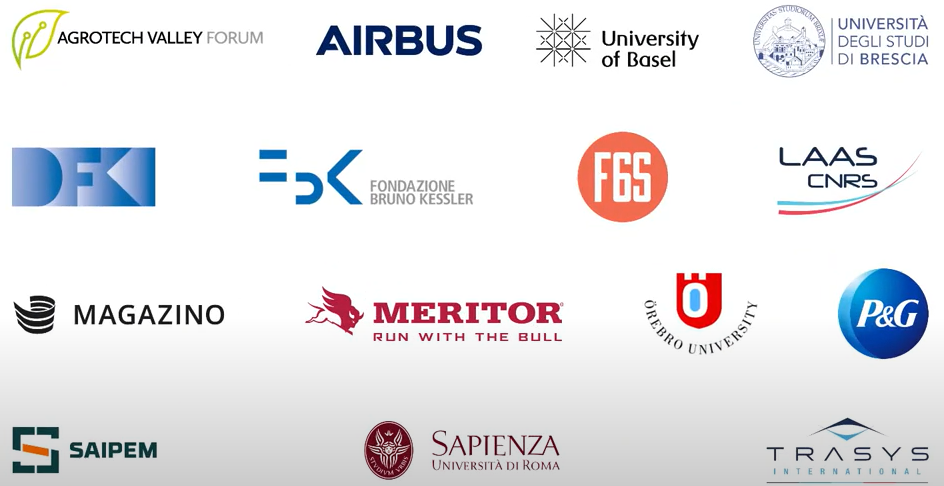

In [ ]:
## O core da aplicacao disponibiliza de maneira unficada diferentes planejadores
### Tais recursos sao utilizados de maneira semelhante a uma API
#### Eh um projeto Open-source e desenvolvido em Python

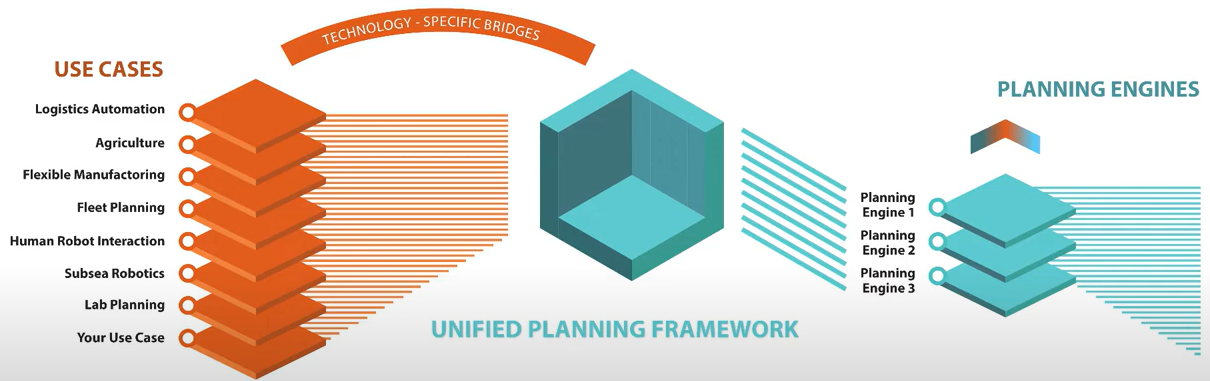

In [ ]:
### Instalacao das bibliotecas

# !pip install --pre -U unified-planning
# !pip install up-pyperplan
# !pip install up-fast-downward
# !pip install up-enhsp
#!pip install up-tamer

In [ ]:
## Definicao do problema
### Suponha que foi dado um grafo (aqui gerado aleatoriamente) de locais,
###  cada qual com uma posicao geometrica associada

import matplotlib.pyplot as plt
import networkx as nx

# Usar semente quando criar o grafo de forma a permitir reprodutibilidade
location_map = nx.soft_random_geometric_graph([f'loc_{i}' for i in range(15)], 0.5, seed=2)
pos = nx.get_node_attributes(location_map, "pos")

# Mostrar o grafo
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(location_map, pos, alpha=0.4)
nx.draw_networkx_nodes(
    location_map,
    pos,
    node_size=1800
)
nx.draw_networkx_labels(location_map, pos)
plt.show()

In [ ]:
# Considere que temos um robo inicialmente localizado em "loc_0" que deseja ir ao "loc_10"

INIT = 'loc_0'
DEST = 'loc_10'

In [ ]:
# Formulacao do planejamento classico

from unified_planning.shortcuts import *

# Primeiro, criamos um tipo chamado "Location"
Location = UserType('Location')

# Criar um novo problema
problem = Problem('robot')

# Declarar os predicados
## robo_em: predicado para modelar a posicao do robo
## conectado: predicado para modelar as relacoes de conectividade do grafo
robot_at = Fluent('robot_at', BoolType(), position=Location)
connected = Fluent("connected", BoolType(), l_from=Location, l_to=Location)

# Adicionar os predicados ao problema
problem.add_fluent(robot_at, default_initial_value=False)
problem.add_fluent(connected, default_initial_value=False)

#Criar uma acao de movimentacao
move = InstantaneousAction('move', l_from=Location, l_to=Location)
l_from = move.parameter('l_from')
l_to = move.parameter('l_to')
move.add_precondition(robot_at(l_from))
move.add_precondition(connected(l_from, l_to))
move.add_effect(robot_at(l_from), False)
move.add_effect(robot_at(l_to), True)
problem.add_action(move)

In [ ]:
# Criacao do mapa, dicionario com o nome do no e representacao deste no como um objeto Location
locations = {str(l): Object(str(l), Location) for l in location_map.nodes}
locations

In [ ]:
# Adicionar todos os objetos no problema
problem.add_objects(locations.values())

# Setar a posicao inicial do robo
problem.set_initial_value(robot_at(locations[INIT]), True)

for(f, t) in location_map.edges:
    problem.set_initial_value(connected(locations[str(f)], locations[str(t)]), True)
    problem.set_initial_value(connected(locations[str(t)], locations[str(f)]), True)

# setar a posicao destino
problem.add_goal(robot_at(locations[DEST]))

print(problem)


In [ ]:
####################################################
### Resolvendo o problema com planejadores classicos
####################################################

for planner_name in ['pyperplan', 'fast-downward']:
    with OneshotPlanner(name=planner_name) as planner:
        result = planner.solve(problem)
        if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
            print(f'{planner_name} found a plan. \nThe plan is: {result.plan}')
        else:
            print("No plan found")

In [ ]:
# Tambem eh possivel deixar o framework escolher, entre os planejadores possiveis,
## um que seja expressivo o bastante para o problema dado

with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print(f'{planner_name} found a plan. \nThe plan is: {result.plan}')
    else:
        print("No plan found")

In [ ]:
## Caracteristicas usada para tal decisao
print(problem.kind.features)

In [ ]:
########################################################################################################################

In [ ]:
####################################################
### Extendendo o problema com predicados numericos
####################################################

import math
from fractions import Fraction

# Uma funcao para simular o custo do uso da bateria em cada edge
def battery_consumption(loc_from, loc_to):
    pos = nx.get_node_attributes(location_map, "pos")
    fx, fy = pos[loc_from]
    tx, ty = pos[loc_to]
    distance = math.sqrt((fx - tx)**2 + (fy - ty)**2)
    return int(5 + distance * 30 + 2)

# Incluindo outros predicados
## - battery: modelar a quantidade residual de energia
## - consumption: modelar o consumo da bateria em cada edge
battery = Fluent('battery', RealType(0,100))
consumption = Fluent('consumption', RealType(), l_from=Location, l_to=Location)

# Adicionar os novos predicados ao problema
problem.add_fluent(battery)
problem.add_fluent(consumption, default_initial_value=-1)

# extender a acao "move"
move.add_precondition(GE(consumption(l_from, l_to),0))
move.add_precondition(GE(battery, consumption(l_from, l_to)))

# setar o etado inicial para os novos predicados
problem.set_initial_value(battery, 100)

for (f,t) in location_map.edges:
    problem.set_initial_value(consumption(locations[str(f)], locations[str(t)]), battery_consumption(f,t))
    problem.set_initial_value(consumption(locations[str(t)], locations[str(f)]), battery_consumption(t,f))

print(problem)

In [ ]:
####################################################
### Resolvendo o problema numerico (recurso)
####################################################

with OneshotPlanner(problem_kind=problem.kind) as planner: #name='tamer'
    result = planner.solve(problem)
    print("%s returned: %s" % (planner.name, result.plan))

In [ ]:
# Ver as caracteristicas do problema
print(problem.kind)

In [ ]:
### Analise dos resultados
import numpy as np
import matplotlib.pyplot as plt

with OneshotPlanner(name='tamer') as planner:
    plan = planner.solve(problem).plan

b = [100]
labels = ['<initial value>']
for ai in plan.actions:
    c = problem.initial_value(consumption(*ai.actual_parameters))
    b.append(b[-1] - c.constant_value())
    labels.append(str(ai))
    
x = list(range(len(plan.actions)+1))
plt.bar(x, b, width=1)

plt.xlabel('Plano')
plt.ylabel('Bateria')
plt.xticks(x, labels, rotation='vertical')
plt.title('Consumo da bateria')
plt.show()